In [3]:
import os

import pandas as pd
from sqlalchemy import create_engine

In [4]:
db_path = os.path.join(os.path.dirname("__file__"), "..", "..", "data", "ufc.db")
engine = create_engine(f"sqlite:///{db_path}")

In [33]:
query = """
WITH cte1 AS 
(
	SELECT
		ufcstats_bouts.id AS bout_id,
		event_id,
		date,
		bout_mapping.fightoddsio_id AS fightoddsio_bout_id,
		red_mapping.fightoddsio_id AS red_fighter_id,
		blue_mapping.fightoddsio_id AS blue_fighter_id,
		CASE
			WHEN
				red_outcome = 'W' 
			THEN
				1 
			WHEN
				red_outcome = 'L' 
			THEN
				0 
			ELSE
				NULL 
		END
		AS red_win 
	FROM
		ufcstats_bouts 
		LEFT JOIN
			ufcstats_events 
			ON ufcstats_bouts.event_id = ufcstats_events.id 
		LEFT JOIN
			bout_mapping 
			ON ufcstats_bouts.id = bout_mapping.ufcstats_id 
		LEFT JOIN
			fighter_mapping AS red_mapping 
			ON ufcstats_bouts.red_fighter_id = red_mapping.ufcstats_id 
		LEFT JOIN
			fighter_mapping AS blue_mapping 
			ON ufcstats_bouts.blue_fighter_id = blue_mapping.ufcstats_id 
	WHERE
		is_ufc_event = 1 
		AND date >= '2021-01-01'
)
, cte2 AS 
(
	SELECT
		ROW_NUMBER() OVER (PARTITION BY bout_id ORDER BY fightoddsio_moneyline_odds.rowid DESC) AS rn,
		bout_id AS fightoddsio_bout_id,
		fighter_1_id,
		fighter_2_id,
		fighter_1_odds_current,
		fighter_2_odds_current 
	FROM
		fightoddsio_moneyline_odds 
		LEFT JOIN
			fightoddsio_bouts 
			ON fightoddsio_moneyline_odds.bout_id = fightoddsio_bouts.id 
	WHERE
		sportsbook_id = 
		(
			SELECT
				id 
			FROM
				fightoddsio_sportsbooks 
			WHERE
				full_name = 'BetOnline'
		)
	ORDER BY
		fightoddsio_bouts.rowid ASC,
		fightoddsio_moneyline_odds.rowid ASC
)
, cte3 AS (
	SELECT 
		fightoddsio_bout_id,
		fighter_1_id,
		fighter_2_id,
		CASE
			WHEN fightoddsio_bout_id = 'RmlnaHROb2RlOjUyNTg3' THEN -118
			WHEN fightoddsio_bout_id = 'RmlnaHROb2RlOjU3MjM1' THEN -330
			ELSE fighter_1_odds_current
		END AS fighter_1_odds_current,
		fighter_2_odds_current
	FROM cte2
    WHERE rn = 1
)
, cte4 AS (
    SELECT
        fightoddsio_bout_id,
        fighter_1_id AS fightoddsio_fighter_id,
        fighter_1_odds_current AS odds
    FROM cte3
    UNION
    SELECT
        fightoddsio_bout_id,
        fighter_2_id AS fightoddsio_fighter_id,
        fighter_2_odds_current AS odds
    FROM cte3
)
SELECT
    bout_id,
    event_id,
    date,
    red_win,
    CASE
		WHEN bout_id = 'dcc0c53100fa1dd2' THEN -270
        ELSE red_mapping.odds
    END AS red_odds,
    CASE
		WHEN bout_id = 'dcc0c53100fa1dd2' THEN 222
		ELSE blue_mapping.odds
	END AS blue_odds
FROM cte1
LEFT JOIN cte4 AS red_mapping
ON cte1.fightoddsio_bout_id = red_mapping.fightoddsio_bout_id
AND cte1.red_fighter_id = red_mapping.fightoddsio_fighter_id
LEFT JOIN cte4 AS blue_mapping
ON cte1.fightoddsio_bout_id = blue_mapping.fightoddsio_bout_id
AND cte1.blue_fighter_id = blue_mapping.fightoddsio_fighter_id
"""

df = pd.read_sql(query, engine)
df

bout_id          event_id        date  red_win  red_odds  \
0     3d903bc35023f50a  307064d3e0f036c2  2021-01-16      0.0       190   
1     97c80f69ac312030  307064d3e0f036c2  2021-01-16      0.0      -185   
2     3fcd53eb27945231  307064d3e0f036c2  2021-01-16      0.0       268   
3     0165bd3c26f0c076  307064d3e0f036c2  2021-01-16      1.0      -191   
4     97ad63e644757cf4  307064d3e0f036c2  2021-01-16      0.0       102   
...                ...               ...         ...      ...       ...   
2052  5238f6470d0557fb  72c9c2eadfc3277e  2024-12-14      0.0       220   
2053  7b1bc4ff776f12c1  72c9c2eadfc3277e  2024-12-14      0.0      -300   
2054  1a635a5e4551e7d5  72c9c2eadfc3277e  2024-12-14      1.0      -400   
2055  7521015554088962  72c9c2eadfc3277e  2024-12-14      1.0       170   
2056  00c6a2ef07ca51da  72c9c2eadfc3277e  2024-12-14      0.0       190   

      blue_odds  
0          -225  
1           160  
2          -318  
3           166  
4          -122  
...         ...  
2052       -260  
2053        250  
2054        300  
2055       -200  
2056       -225  

[2057 rows x 6 columns]

In [35]:
temp = pd.read_csv(os.path.join(os.path.dirname("__file__"), "..", "..", "data", "backtest_odds_betonline.csv"))
temp

bout_id          event_id        date  red_win  red_odds  \
0     3d903bc35023f50a  307064d3e0f036c2  2021-01-16      0.0       190   
1     97c80f69ac312030  307064d3e0f036c2  2021-01-16      0.0      -185   
2     3fcd53eb27945231  307064d3e0f036c2  2021-01-16      0.0       268   
3     0165bd3c26f0c076  307064d3e0f036c2  2021-01-16      1.0      -191   
4     97ad63e644757cf4  307064d3e0f036c2  2021-01-16      0.0       102   
...                ...               ...         ...      ...       ...   
2052  5238f6470d0557fb  72c9c2eadfc3277e  2024-12-14      0.0       220   
2053  7b1bc4ff776f12c1  72c9c2eadfc3277e  2024-12-14      0.0      -300   
2054  1a635a5e4551e7d5  72c9c2eadfc3277e  2024-12-14      1.0      -400   
2055  7521015554088962  72c9c2eadfc3277e  2024-12-14      1.0       170   
2056  00c6a2ef07ca51da  72c9c2eadfc3277e  2024-12-14      0.0       190   

      blue_odds  
0          -225  
1           160  
2          -318  
3           166  
4          -122  
...         ...  
2052       -260  
2053        250  
2054        300  
2055       -200  
2056       -225  

[2057 rows x 6 columns]

In [37]:
temp.equals(df)

True

In [6]:
query = """
SELECT * FROM ufcstats_bouts
WHERE event_id IN (
    SELECT id FROM ufcstats_events
    WHERE is_ufc_event = 1 AND date >= '2021-01-01'
)
ORDER BY rowid ASC;
"""

test_df = pd.read_sql(query, engine)
test_df

id          event_id  bout_order    red_fighter_id  \
0     3d903bc35023f50a  307064d3e0f036c2           1  637bd06c32219f0b   
1     97c80f69ac312030  307064d3e0f036c2           2  539ed332b3078821   
2     3fcd53eb27945231  307064d3e0f036c2           3  3bb2dc8e87b10a46   
3     0165bd3c26f0c076  307064d3e0f036c2           4  a2ea77e974c5889f   
4     97ad63e644757cf4  307064d3e0f036c2           5  fdbefee0827e1567   
...                ...               ...         ...               ...   
2052  5238f6470d0557fb  72c9c2eadfc3277e           9  0232cabbc30a2372   
2053  7b1bc4ff776f12c1  72c9c2eadfc3277e          10  71171fc96445bf65   
2054  1a635a5e4551e7d5  72c9c2eadfc3277e          11  5d1b7e3dd9e11074   
2055  7521015554088962  72c9c2eadfc3277e          12  d247691a6c0e9034   
2056  00c6a2ef07ca51da  72c9c2eadfc3277e          13  dc9572dd6ec74859   

       blue_fighter_id red_outcome blue_outcome          weight_class  \
0     305d73ede05e31ad           L            W         Featherweight   
1     9b7dfb3b7d99926a           L            W  Women's Bantamweight   
2     abd5fb12437eda21           L            W          Welterweight   
3     e13abac8089a801a           W            L           Heavyweight   
4     f9ab66e67240db7b           L            W  Women's Bantamweight   
...                ...         ...          ...                   ...   
2052  850266b3dc4e506e           L            W          Bantamweight   
2053  e4277e87a789d687           L            W     Light Heavyweight   
2054  294aa73dbf37d281           W            L             Flyweight   
2055  aa171d55d4b5208f           W            L         Featherweight   
2056  b9437600497350f3           L            W          Welterweight   

                   type_verbose  performance_bonus           outcome_method  \
0            Featherweight Bout                  0     Decision - Unanimous   
1     Women's Bantamweight Bout                  0     Decision - Unanimous   
2             Welterweight Bout                  0         Decision - Split   
3              Heavyweight Bout                  0         Decision - Split   
4     Women's Bantamweight Bout                  0     Decision - Unanimous   
...                         ...                ...                      ...   
2052          Bantamweight Bout                  0         Decision - Split   
2053     Light Heavyweight Bout                  1                   KO/TKO   
2054             Flyweight Bout                  0                   KO/TKO   
2055         Featherweight Bout                  0                   KO/TKO   
2056          Welterweight Bout                  0  TKO - Doctor's Stoppage   

                                 outcome_method_details  end_round  \
0     David Lethaby 26 - 30. Paul Sutherland 26 - 30...          3   
1     Lukasz Bosacki 27 - 30. Anders Ohlsson 28 - 29...          3   
2     Ben Cartlidge 28 - 29. Mike Bell 29 - 28. Davi...          3   
3     Lukasz Bosacki 28 - 29. Anders Ohlsson 29 - 28...          3   
4     Lukasz Bosacki 27 - 30. Anders Ohlsson 27 - 30...          3   
...                                                 ...        ...   
2052  Derek Cleary 27 - 30. Chris Lee 29 - 28. Eric ...          3   
2053                          Punch to Head At Distance          3   
2054                        Punches to Head At Distance          3   
2055                          Punch to Head At Distance          3   
2056                                      Cut above eye          3   

      end_round_time_seconds  round_time_format  total_time_seconds  
0                        300      3 Rnd (5-5-5)                 900  
1                        300      3 Rnd (5-5-5)                 900  
2                        300      3 Rnd (5-5-5)                 900  
3                        300      3 Rnd (5-5-5)                 900  
4                        300      3 Rnd (5-5-5)                 900  
...                      ...                

In [7]:
len(test_df["event_id"].unique())

170

In [8]:
query = """
SELECT * FROM ufcstats_bouts
WHERE event_id IN (
    SELECT id FROM ufcstats_events
    WHERE is_ufc_event = 1 AND date >= '2008-04-19' AND date < '2021-01-01'
) AND red_outcome IN ('W', 'L')
ORDER BY rowid ASC;
"""

train_df = pd.read_sql(query, engine)
train_df

id          event_id  bout_order    red_fighter_id  \
0     be38ed9ccfe2ee03  ad047e3073a775f3           1  fb1538b46877a695   
1     eb1b371dfc37fcdb  ad047e3073a775f3           2  0ff11cc094e887bc   
2     219bd976b8ca745d  ad047e3073a775f3           3  501b07aec9b8fc2d   
3     af178adff964d854  ad047e3073a775f3           4  06f36cf4bd97ec77   
4     920194911d727a38  ad047e3073a775f3           5  4130a743d9d22163   
...                ...               ...         ...               ...   
4920  cd150cd28738a7c5  e49c2db95e572dc8           8  c9cf753cfdf77fc2   
4921  8955ea3c7c332e6c  e49c2db95e572dc8           9  fea79f9bc8c68769   
4922  3d35eb2d46bf74de  e49c2db95e572dc8          10  595db60957de51d3   
4923  014f1da2083ca174  e49c2db95e572dc8          11  d0f3959b4a9747e6   
4924  c7375d5db21cbaae  e49c2db95e572dc8          12  4a28cb716c19157a   

       blue_fighter_id red_outcome blue_outcome  weight_class  \
0     9d4522df6fc49a47           W            L  Welterweight   
1     6803d4d6908354ac           W            L   Heavyweight   
2     7d21de9c6d7c98b2           L            W   Lightweight   
3     427b5953ac8e3a27           L            W  Middleweight   
4     a6fd2173d5e2d7f0           L            W  Middleweight   
...                ...         ...          ...           ...   
4920  85073dbd1be65ed9           W            L   Heavyweight   
4921  05339613bf8e9808           L            W  Bantamweight   
4922  2558ae2e5671e318           W            L  Welterweight   
4923  7c7332319c14094c           W            L  Bantamweight   
4924  b997be68943010fc           W            L  Welterweight   

           type_verbose  performance_bonus        outcome_method  \
0     Welterweight Bout                  0                KO/TKO   
1      Heavyweight Bout                  0                KO/TKO   
2      Lightweight Bout                  0      Decision - Split   
3     Middleweight Bout                  1            Submission   
4     Middleweight Bout                  0                KO/TKO   
...                 ...                ...                   ...   
4920   Heavyweight Bout                  1                KO/TKO   
4921  Bantamweight Bout                  1                KO/TKO   
4922  Welterweight Bout                  0  Decision - Unanimous   
4923  Bantamweight Bout                  0  Decision - Unanimous   
4924  Welterweight Bout                  1  Decision - Unanimous   

                                 outcome_method_details  end_round  \
0                             Punch to Head At Distance          2   
1                     Punches to Head From Side Control          1   
2     Doug Crosby 27 - 29. Sylvain Leblanc 29 - 28. ...          3   
3     Triangle Choke From Bottom Guard Technical Sub...          2   
4                           Punches to Head At Distance          1   
...                                                 ...        ...   
4920                    Punches to Head From Half Guard          2   
4921                          Punches to Head On Ground          1   
4922  Mike Bell 28 - 29. Eric Colon 28 - 29. Tony We...          3   
4923  Mike Bell 28 - 29. Eric Colon 28 - 29. Ron McC...          3   
4924  Derek Cleary 45 - 50. Sal D'amato 45 - 50. Jun...          5   

      end_round_time_seconds  round_time_format  total_time_seconds  
0                        127      3 Rnd (5-5-5)                 427  
1                        130      3 Rnd (5-5-5)                 130  
2                        300      3 Rnd (5-5-5)                 900  
3                        147      3 Rnd (5-5-5)                 447  
4                        238      3 Rnd (5-5-5)                 238  
...                      ...                ...                 ...  
4920                     271      3 Rnd (5-5-5)                 571  
4921                     227      3 Rnd (5-5-5)                 227  
4922                     300      3 Rnd (5-5-5)               

In [9]:
len(train_df["event_id"].unique())

439

In [54]:
query = """
SELECT bout_id AS fightoddsio_bout_id, fighter_1_id, fighter_2_id, fighter_1_odds_current, fighter_2_odds_current
FROM fightoddsio_moneyline_odds
LEFT JOIN fightoddsio_bouts ON fightoddsio_moneyline_odds.bout_id = fightoddsio_bouts.id
WHERE sportsbook_id = (
    SELECT id FROM fightoddsio_sportsbooks
    WHERE full_name = 'BetOnline'
)
ORDER BY fightoddsio_bouts.rowid ASC, fightoddsio_moneyline_odds.rowid ASC;
"""

betonline_odds = pd.read_sql(query, engine).drop_duplicates(keep="last", subset=["fightoddsio_bout_id"])
f1_odds = betonline_odds[["fightoddsio_bout_id", "fighter_1_id", "fighter_1_odds_current"]].rename({"fighter_1_id": "fighter_id", "fighter_1_odds_current": "odds"}, axis=1)
f2_odds = betonline_odds[["fightoddsio_bout_id", "fighter_2_id", "fighter_2_odds_current"]].rename({"fighter_2_id": "fighter_id", "fighter_2_odds_current": "odds"}, axis=1)
odds_df = pd.concat([f1_odds, f2_odds])
odds_df

fightoddsio_bout_id                fighter_id   odds
0     RmlnaHROb2RlOjE0OTE2      RmlnaHRlck5vZGU6NzI4  100.0
1     RmlnaHROb2RlOjE0OTkw  RmlnaHRlck5vZGU6MTA3OA==  250.0
2     RmlnaHROb2RlOjE1NTc0  RmlnaHRlck5vZGU6MTIxOQ== -290.0
3     RmlnaHROb2RlOjE1MDAw  RmlnaHRlck5vZGU6MzQwNg== -500.0
4     RmlnaHROb2RlOjE0OTY4  RmlnaHRlck5vZGU6MTM1Mg== -300.0
...                    ...                       ...    ...
3440  RmlnaHROb2RlOjU3Mzcy  RmlnaHRlck5vZGU6Mzg5MTU= -260.0
3441  RmlnaHROb2RlOjU2NzY3  RmlnaHRlck5vZGU6MTcxNDI=  300.0
3442  RmlnaHROb2RlOjU2OTcw  RmlnaHRlck5vZGU6MTQ5MTk= -200.0
3443  RmlnaHROb2RlOjU3NjE2  RmlnaHRlck5vZGU6ODk5Mw== -225.0
3444  RmlnaHROb2RlOjU3MjU0  RmlnaHRlck5vZGU6MTE4Mjg=  400.0

[6888 rows x 3 columns]

In [ ]:
query = """
SELECT 
    ufcstats_bouts.id AS bout_id, 
    event_id, 
    date, 
    bout_mapping.fightoddsio_id AS fightoddsio_bout_id, 
    red_mapping.fightoddsio_id AS red_fighter_id, 
    blue_mapping.fightoddsio_id AS blue_fighter_id,
    CASE
        WHEN red_outcome = 'W' THEN 1
        WHEN red_outcome = 'L' THEN 0
        ELSE NULL
    END AS red_win
FROM ufcstats_bouts
LEFT JOIN ufcstats_events ON ufcstats_bouts.event_id = ufcstats_events.id
LEFT JOIN bout_mapping ON ufcstats_bouts.id = bout_mapping.ufcstats_id
LEFT JOIN fighter_mapping AS red_mapping ON ufcstats_bouts.red_fighter_id = red_mapping.ufcstats_id
LEFT JOIN fighter_mapping AS blue_mapping ON ufcstats_bouts.blue_fighter_id = blue_mapping.ufcstats_id
WHERE is_ufc_event = 1 AND date >= '2021-01-01'
"""

backtest_df = pd.read_sql(query, engine)
backtest_df = backtest_df.merge(odds_df, left_on=["fightoddsio_bout_id", "red_fighter_id"], right_on=["fightoddsio_bout_id", "fighter_id"], how="left").drop(["red_fighter_id", "fighter_id"], axis=1).rename({"odds": "red_odds"}, axis=1)
backtest_df = backtest_df.merge(odds_df, left_on=["fightoddsio_bout_id", "blue_fighter_id"], right_on=["fightoddsio_bout_id", "fighter_id"], how="left").drop(["blue_fighter_id", "fighter_id"], axis=1).rename({"odds": "blue_odds"}, axis=1)

# from oddsportal
backtest_df.loc[backtest_df["fightoddsio_bout_id"] == "RmlnaHROb2RlOjUyNTg3", "red_odds"] = -118
backtest_df.loc[backtest_df["fightoddsio_bout_id"] == "RmlnaHROb2RlOjU3MjM1", "red_odds"] = -330
backtest_df.loc[backtest_df["fightoddsio_bout_id"] == "RmlnaHROb2RlOjUzMTc2", "red_odds"] = -270
backtest_df.loc[backtest_df["fightoddsio_bout_id"] == "RmlnaHROb2RlOjUzMTc2", "blue_odds"] = 222
backtest_df["red_odds"] = backtest_df["red_odds"].astype(int)
backtest_df["blue_odds"] = backtest_df["blue_odds"].astype(int)
backtest_df["red_win"] = backtest_df["red_win"].astype("Int64")
backtest_df = backtest_df.drop("fightoddsio_bout_id", axis=1)
backtest_df

bout_id          event_id        date  red_win  red_odds  \
0     3d903bc35023f50a  307064d3e0f036c2  2021-01-16        0       190   
1     97c80f69ac312030  307064d3e0f036c2  2021-01-16        0      -185   
2     3fcd53eb27945231  307064d3e0f036c2  2021-01-16        0       268   
3     0165bd3c26f0c076  307064d3e0f036c2  2021-01-16        1      -191   
4     97ad63e644757cf4  307064d3e0f036c2  2021-01-16        0       102   
...                ...               ...         ...      ...       ...   
2052  5238f6470d0557fb  72c9c2eadfc3277e  2024-12-14        0       220   
2053  7b1bc4ff776f12c1  72c9c2eadfc3277e  2024-12-14        0      -300   
2054  1a635a5e4551e7d5  72c9c2eadfc3277e  2024-12-14        1      -400   
2055  7521015554088962  72c9c2eadfc3277e  2024-12-14        1       170   
2056  00c6a2ef07ca51da  72c9c2eadfc3277e  2024-12-14        0       190   

      blue_odds  
0          -225  
1           160  
2          -318  
3           166  
4          -122  
...         ...  
2052       -260  
2053        250  
2054        300  
2055       -200  
2056       -225  

[2057 rows x 6 columns]

In [66]:
def calculate_implied_prob(red_odds, blue_odds):
    if red_odds < 0:
        red_prob = abs(red_odds) / (abs(red_odds) + 100)
    else:
        red_prob = 100 / (red_odds + 100)
    
    if blue_odds < 0:
        blue_prob = abs(blue_odds) / (abs(blue_odds) + 100)
    else:
        blue_prob = 100 / (blue_odds + 100)

    red_implied_prob = red_prob / (red_prob + blue_prob)

    return red_implied_prob

backtest_df["red_implied_prob_no_vig"] = backtest_df.apply(lambda x: calculate_implied_prob(x["red_odds"], x["blue_odds"]), axis=1)
backtest_df

bout_id          event_id        date  red_win  red_odds  \
0     3d903bc35023f50a  307064d3e0f036c2  2021-01-16        0       190   
1     97c80f69ac312030  307064d3e0f036c2  2021-01-16        0      -185   
2     3fcd53eb27945231  307064d3e0f036c2  2021-01-16        0       268   
3     0165bd3c26f0c076  307064d3e0f036c2  2021-01-16        1      -191   
4     97ad63e644757cf4  307064d3e0f036c2  2021-01-16        0       102   
...                ...               ...         ...      ...       ...   
2052  5238f6470d0557fb  72c9c2eadfc3277e  2024-12-14        0       220   
2053  7b1bc4ff776f12c1  72c9c2eadfc3277e  2024-12-14        0      -300   
2054  1a635a5e4551e7d5  72c9c2eadfc3277e  2024-12-14        1      -400   
2055  7521015554088962  72c9c2eadfc3277e  2024-12-14        1       170   
2056  00c6a2ef07ca51da  72c9c2eadfc3277e  2024-12-14        0       190   

      blue_odds  red_implied_prob_no_vig  
0          -225                 0.332481  
1           160                 0.627937  
2          -318                 0.263184  
3           166                 0.635822  
4          -122                 0.473913  
...         ...                      ...  
2052       -260                 0.302013  
2053        250                 0.724138  
2054        300                 0.761905  
2055       -200                 0.357143  
2056       -225                 0.332481  

[2057 rows x 7 columns]

In [67]:
backtest_df2 = backtest_df.loc[backtest_df["red_win"].notnull()]
backtest_df2

bout_id          event_id        date  red_win  red_odds  \
0     3d903bc35023f50a  307064d3e0f036c2  2021-01-16        0       190   
1     97c80f69ac312030  307064d3e0f036c2  2021-01-16        0      -185   
2     3fcd53eb27945231  307064d3e0f036c2  2021-01-16        0       268   
3     0165bd3c26f0c076  307064d3e0f036c2  2021-01-16        1      -191   
4     97ad63e644757cf4  307064d3e0f036c2  2021-01-16        0       102   
...                ...               ...         ...      ...       ...   
2052  5238f6470d0557fb  72c9c2eadfc3277e  2024-12-14        0       220   
2053  7b1bc4ff776f12c1  72c9c2eadfc3277e  2024-12-14        0      -300   
2054  1a635a5e4551e7d5  72c9c2eadfc3277e  2024-12-14        1      -400   
2055  7521015554088962  72c9c2eadfc3277e  2024-12-14        1       170   
2056  00c6a2ef07ca51da  72c9c2eadfc3277e  2024-12-14        0       190   

      blue_odds  red_implied_prob_no_vig  
0          -225                 0.332481  
1           160                 0.627937  
2          -318                 0.263184  
3           166                 0.635822  
4          -122                 0.473913  
...         ...                      ...  
2052       -260                 0.302013  
2053        250                 0.724138  
2054        300                 0.761905  
2055       -200                 0.357143  
2056       -225                 0.332481  

[2020 rows x 7 columns]

In [68]:
from sklearn.metrics import log_loss
from sklearn.calibration import CalibrationDisplay

log_loss(backtest_df2["red_win"], backtest_df2["red_implied_prob_no_vig"])

0.6020389967661395

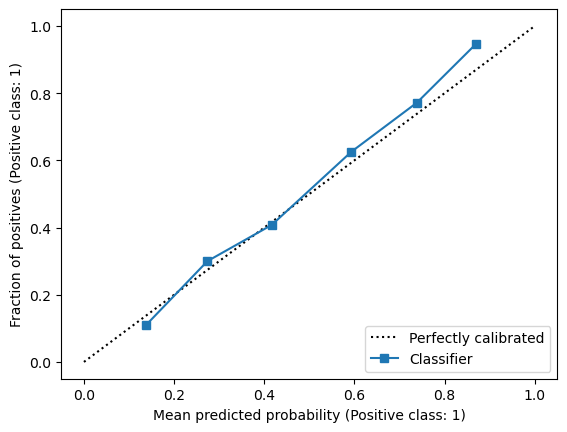

In [76]:
disp = CalibrationDisplay.from_predictions(backtest_df2["red_win"], backtest_df2["red_implied_prob_no_vig"], n_bins=6)